# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

### Import required modules

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

### Already provided helper funtions from project problem statement

In [2]:
# not used till now
def length_line(x1,y1,x2,y2):
    return ( (((float(x2)-float(x1))**2) + ((float(y2)-float(y1))**2)) ** 0.5)

# not used till now
def extrapolate_line(y_max, y_min, x1, y1, x2, y2):
    #print ("extrapolating a line")
    if x1 != x2 and length_line(x1,y1,x2,y2) > 30:
        m = ((float(y2)-float(y1))/(float(x2)-float(x1)))
        #print (m)
        c = ((float(x2)*float(y1)) - (float(x1)*float(y1)) - (float(x1)*float(y2)) + (float(x1)*float(y1))) / (float(x2)-float(x1)) 
        #print (c)
        if m != 0:
            if y1<y2:
                y1 = y_min
                y2 = y_max  
            else:
                y1 = y_max
                y2 = y_min
                
            x1 = (y1 - c)/m
            x2 = (y2 -c )/m
            
    return int(x1),int(y1),int(x2),int(y2)

# provided by problem statement
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# provided by problem statement
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

# provided by problem statement
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# provided by problem statement
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# provided by problem statement not used
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


# provided by problem statement
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),    minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    return lines

### This is main function to process the image and retruns image with lane markings drawn

In [3]:
def process_image(image):
    """
    main function to detect lane lines
    step 01:- get gray image
    step 02:- do gaussian blur
    step 03:- do canny edge detction
    step 04:- region of interset
    step 05:- get lane lines from hough transform
    step 06:- seperate left and right lines
    step 07:- get left and right lines slopes, can be done with step 6 although
    step 08:- delete left lines which deviate from thersold_s slope
    step 09:- delete right lines which deviate from average slope
    step 10:- extrapolate left and right lines
    step 11:- check if left/right line is out of ROI
    step 12:- draw lines
    
    """
    
    # (step 1) get gray image
    gray = grayscale(image)
    
    # (step 2) do gaussian blur with kernel size is 3
    blur_gray = gaussian_blur(gray, 3)
    
    # (step 3) do canny edge detction with low 50 and hight 150
    canny_edges = canny(blur_gray, 50, 150)
    
    # (step 4) region of interset
    imshape = image.shape
    left_bottom = (50,imshape[0])
    right_bottom = (imshape[1]-50,imshape[0])
    left_top = (420, 330)
    right_top = (imshape[1]-420, 330)
    # used later to discard lines which are out of the ROI
    polygon = Polygon([(50,imshape[0]+1),(imshape[1]-50,imshape[0]+1), (imshape[1]-420, 329), (420, 329)])
    vertices = np.array([[left_bottom,left_top, right_top, right_bottom]], dtype=np.int32)
    masked_edge = region_of_interest(canny_edges, vertices)
    
    # (step 5) get lane lines from hough transform
    rho = 2
    theta = np.pi/18 
    threshold = 30
    min_line_length = 10
    max_line_gap = 20
    lines = hough_lines(masked_edge, rho, theta, threshold, min_line_length, max_line_gap)
    
    # (step 6) seperate left and right lines
    left_lines = []
    right_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if y1 > y2:
                temp_line = [x1,y1,x2,y2]
                if x2 != x1:
                    m =  (float(y2) - float(y1)) / (float(x2) - float(x1))
                else:
                    m = 1000 # it will be dicarded, any high value will work
                temp_line.append(m)
                if x1 < x2:
                    left_lines.append(temp_line)
                else:
                    right_lines.append(temp_line)
            else:
                temp_line = [x2,y2,x1,y1]
                if x2 != x1:
                    m =  (float(y1) - float(y2)) / (float(x1) - float(x2))
                else:
                    m = 1000
                temp_line.append(m)
                if x1 > x2:
                    left_lines.append(temp_line)
                else:
                    right_lines.append(temp_line)
    
    # (step 7) get left and right lines slopes, can be done with step 6 although
    left_slop = []
    for left_line in left_lines:
        x1 = left_line[0]; y1 = left_line[1]; x2 = left_line[2]; y2 = left_line[3]; 
        if x1 != x2:
            left_slop.append( (float(y2) - float(y1)) / (float(x2) - float(x1)) )
    average_left_slop = sum(left_slop)/len(left_slop) # not used yet
    
    right_slop = []
    for right_line in right_lines:
        x1 = right_line[0]; y1 = right_line[1]; x2 = right_line[2]; y2 = right_line[3]; 
        if x1 != x2:
            right_slop.append( (float(y2) - float(y1)) / (float(x2) - float(x1)) )
    average_right_slope = sum(right_slop)/len(right_slop) # not used yet
    
    
    # (step 8) delete left lines which deviate from thersold_s slope
    thersold_s = 0.5
    delet_left_index = []
    i = 0
    for left_line in left_lines:
        x1 = left_line[0]; y1 = left_line[1]; x2 = left_line[2]; y2 = left_line[3]; m = left_line[4]; 
        if abs(m) < thersold_s:
            delet_left_index.append(i)
        i=i+1
    for i in range((len(delet_left_index)-1), -1, -1):
        del left_lines[delet_left_index[i]]
        
    # (step 9) delete right lines which deviate from average slope
    delet_index_right = []
    i = 0
    for right_line in right_lines:
        x1 = right_line[0]; y1 = right_line[1]; x2 = right_line[2]; y2 = right_line[3]; m = right_line[4]; 
        if abs(m) < thersold_s:
            delet_index_right.append(i)
        i=i+1
    for i in range((len(delet_index_right)-1), -1, -1):
        del right_lines[delet_index_right[i]]
        
    # (step 10) extrapolate left and right lines
    left_line_draw = True
    x_lefts = []
    y_lefts = []
    for line in left_lines:
        x1, y1, x2, y2, m = line
        x_lefts.append(x1)
        x_lefts.append(x2) 
        y_lefts.append(y1)
        y_lefts.append(y2)
        
    if len(x_lefts) > 0:
        slope_left, c_left = np.polyfit(x_lefts, y_lefts, 1)
    else:
        slope_left, c_left = 1, 1
        left_line_draw = False
    
    right_line_draw = True
    x_rights = []
    y_rights = []
    for line in right_lines:
        x1, y1, x2, y2, m = line
        x_rights.append(x1)
        x_rights.append(x2)
        y_rights.append(y1)
        y_rights.append(y2)
    if len(x_rights) > 0:
        slope_right, c_right = np.polyfit(x_rights, y_rights, 1)
    else:
        slope_right, c_right = 1, 1
        right_line_draw = False
        
    y1_left = 530 # again hardcoded values, from ROI
    y2_left = 330 # again hardcoded values, from ROI
    x1_left = int((y1_left - c_left) / slope_left)
    x2_left = int((y2_left - c_left) / slope_left)
    
    y1_right = 530 # again hardcoded values, from ROI
    y2_right = 330 # again hardcoded values, from ROI    
    x1_right = int((y1_right - c_right) / slope_right)
    x2_right = int((y2_right - c_right) / slope_right)
     
    # (step 11) check if left/right line is out of ROI
    left_point1 = Point(x1_left, y1_left)
    left_point2 = Point(x2_left, y2_left)
    
    right_point1 = Point(x1_right, y1_right)
    right_point2 = Point(x2_right, y2_right)
    
    if polygon.contains(left_point1) and polygon.contains(left_point2):
        left_line_draw = True
    else:
        #print ("left line out", left_point1, left_point2)
        left_line_draw = False
        
    if polygon.contains(right_point1) and polygon.contains(right_point2):
        right_line_draw = True
    else:
        #print ("right line out", right_point1, right_point2)
        right_line_draw = False
    
          
    # (step 12) draw lines
    line_image = np.copy(image)
    # Draw the right and left lines on image
    if left_line_draw:
        cv2.line(line_image, (x1_left, y1_left), (x2_left, y2_left), (255,0,0),5)
    if right_line_draw:
        cv2.line(line_image, (x1_right, y1_right), (x2_right, y2_right), (255,0,0),5)
           
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((masked_edge, masked_edge, masked_edge)) 
    
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.4, line_image, 1, 0) 
    #plt.imshow(lines_edges)
    #plt.show()
    return lines_edges

### Test on images.

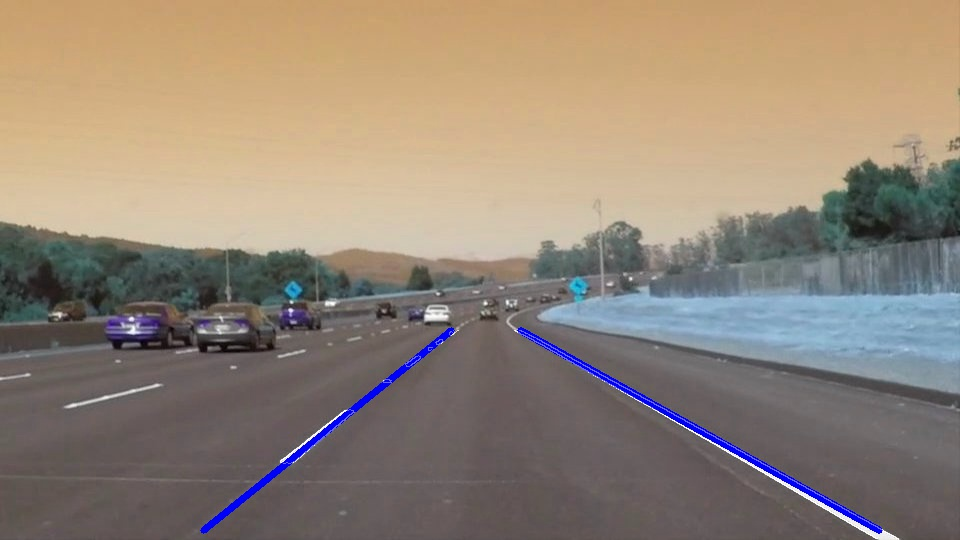

In [4]:
# test images
cv2.imwrite('test_images/solidWhiteCurve_output.jpg',process_image(mpimg.imread('test_images/solidWhiteCurve.jpg')))
cv2.imwrite('test_images/solidWhiteRight_output.jpg',process_image(mpimg.imread('test_images/solidWhiteRight.jpg')))
cv2.imwrite('test_images/solidYellowCurve_output.jpg',process_image(mpimg.imread('test_images/solidYellowCurve.jpg')))
cv2.imwrite('test_images/solidYellowCurve2_output.jpg',process_image(mpimg.imread('test_images/solidYellowCurve2.jpg')))
cv2.imwrite('test_images/solidYellowLeft_output.jpg',process_image(mpimg.imread('test_images/solidYellowLeft.jpg')))
cv2.imwrite('test_images/whiteCarLaneSwitch_output.jpg',process_image(mpimg.imread('test_images/whiteCarLaneSwitch.jpg')))
from IPython.display import Image
Image(filename='test_images/solidWhiteCurve_output.jpg') # displaying only one.


### Test white lane marking vedio

In [5]:
# test videos
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 14.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 



### Test yellow lane marking video

In [6]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
yellow_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:45<00:00, 14.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

